In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import interpolate
from scipy.integrate import simpson
from matplotlib.widgets import Slider
from tqdm import tqdm
import multiprocessing as mp

import src
from src.nc4.BJDSprialScan import processExpSprialScans, NC4SpiralScan

%load_ext autoreload
%autoreload 2

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()
TESTING_DIR = BASE_DIR / 'AE/TESTING'

In [3]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [5]:
expLabels = [
    'Test 5',
    'Test 7',
    'Test 8',
    'Test 9',
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
    'Test 22',
    'Test 23',
    'Test 24'
]

exps = [src.load(label) for label in expLabels]

In [6]:
for exp in exps:
    print(exp)
    # print(exp.features.head())
    print()

Test No: 5
Date: 2022-08-03
Data: ..\..\AE\Testing\22_08_03_grit1000
No. Files: AE-213 NC4-214

Test No: 7
Date: 2022-11-07
Data: ..\..\AE\Testing\22_11_07_weartest_1000
No. Files: AE-163 NC4-164

Test No: 8
Date: 2022-11-09
Data: ..\..\AE\Testing\22_11_09_weartest_1000
No. Files: AE-176 NC4-177

Test No: 9
Date: 2022-11-30
Data: ..\..\AE\Testing\22_11_30_weartest_1000
No. Files: AE-158 NC4-159

Test No: 11
Date: 2024-05-28
Data: ..\..\AE\Testing\24_05_28_weartest_D1.3#1000
No. Files: AE-139 NC4-140

Test No: 14
Date: 2024-06-10
Data: ..\..\AE\Testing\24_06_10_weartest_D1.3_#1000
No. Files: AE-125 NC4-126

Test No: 15
Date: 2024-06-19
Data: ..\..\AE\Testing\24_06_19_weartest_D1.3_#1000
No. Files: AE-141 NC4-142

Test No: 16
Date: 2024-07-03
Data: ..\..\AE\Testing\24_07_03_weartest_D1.3_#1000
No. Files: AE-141 NC4-142

Test No: 17
Date: 2024-07-24
Data: ..\..\AE\Testing\24_07_24_weartest_D1.3_#1000
No. Files: AE-139 NC4-140

Test No: 18
Date: 2024-07-31
Data: ..\..\AE\Testing\24_07_31_w

Test No: 5
Date: 2022-08-03
Data: ..\..\AE\Testing\22_08_03_grit1000
No. Files: AE-213 NC4-214
Test No: 7
Date: 2022-11-07
Data: ..\..\AE\Testing\22_11_07_weartest_1000
No. Files: AE-163 NC4-164
Test No: 8
Date: 2022-11-09
Data: ..\..\AE\Testing\22_11_09_weartest_1000
No. Files: AE-176 NC4-177
Test No: 9
Date: 2022-11-30
Data: ..\..\AE\Testing\22_11_30_weartest_1000
No. Files: AE-158 NC4-159
Test No: 11
Date: 2024-05-28
Data: ..\..\AE\Testing\24_05_28_weartest_D1.3#1000
No. Files: AE-139 NC4-140


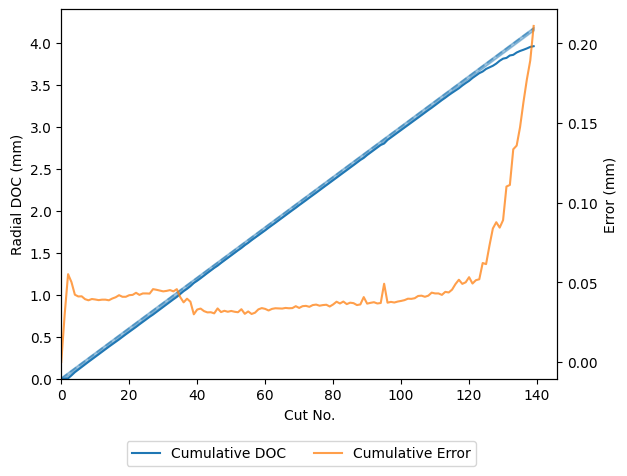

Test No: 14
Date: 2024-06-10
Data: ..\..\AE\Testing\24_06_10_weartest_D1.3_#1000
No. Files: AE-125 NC4-126


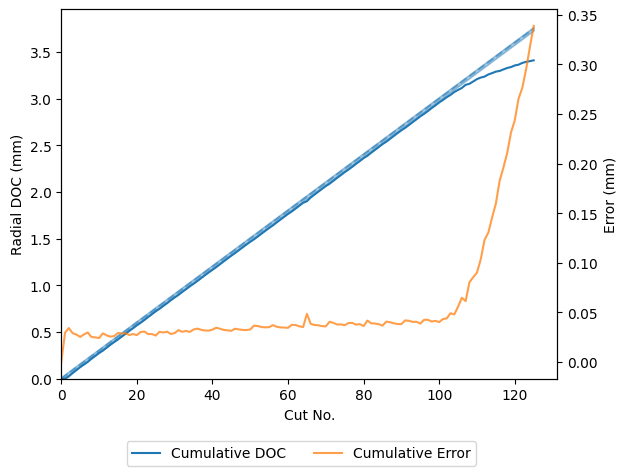

Test No: 15
Date: 2024-06-19
Data: ..\..\AE\Testing\24_06_19_weartest_D1.3_#1000
No. Files: AE-141 NC4-142


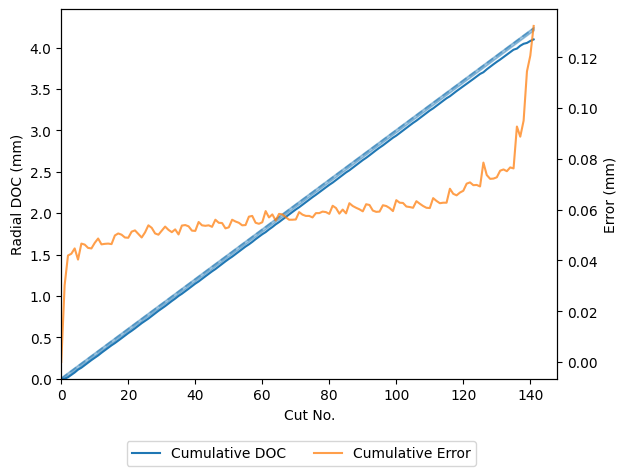

Test No: 16
Date: 2024-07-03
Data: ..\..\AE\Testing\24_07_03_weartest_D1.3_#1000
No. Files: AE-141 NC4-142


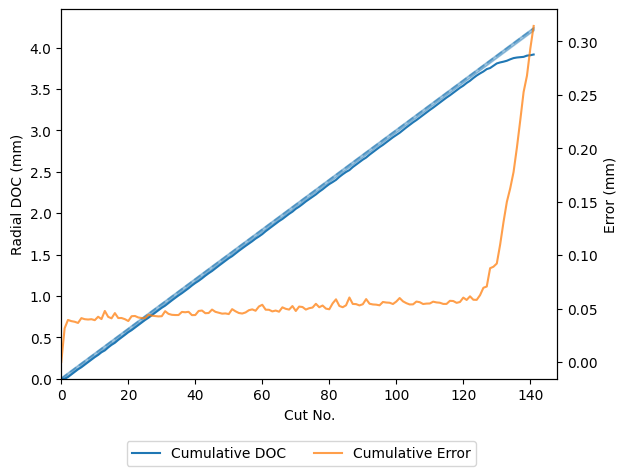

Test No: 17
Date: 2024-07-24
Data: ..\..\AE\Testing\24_07_24_weartest_D1.3_#1000
No. Files: AE-139 NC4-140


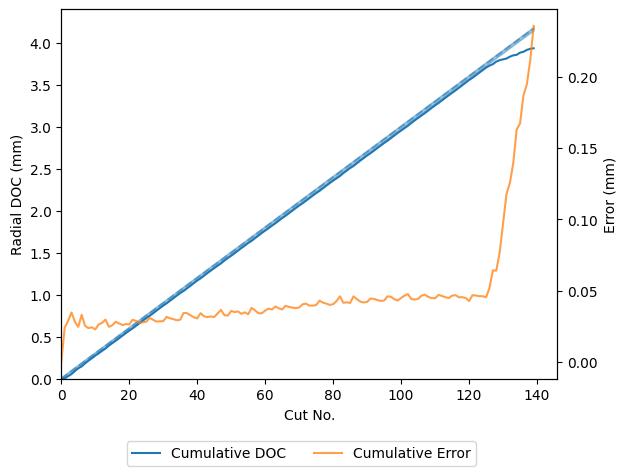

Test No: 18
Date: 2024-07-31
Data: ..\..\AE\Testing\24_07_31_weartest_D1.3_#1000
No. Files: AE-135 NC4-136


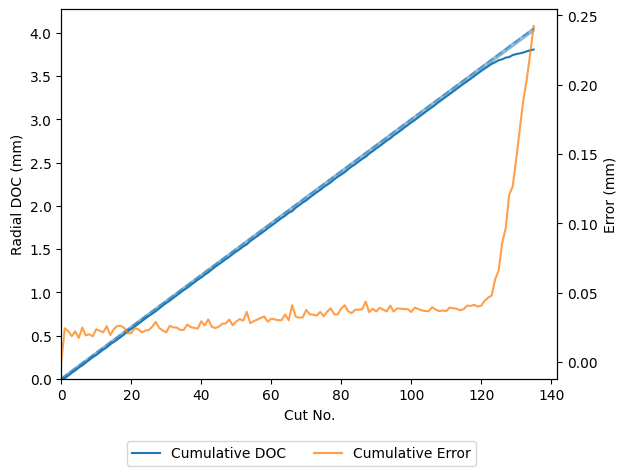

Test No: 19
Date: 2024-08-05
Data: ..\..\AE\Testing\24_08_05_weartest_D1.3_#1000
No. Files: AE-140 NC4-141


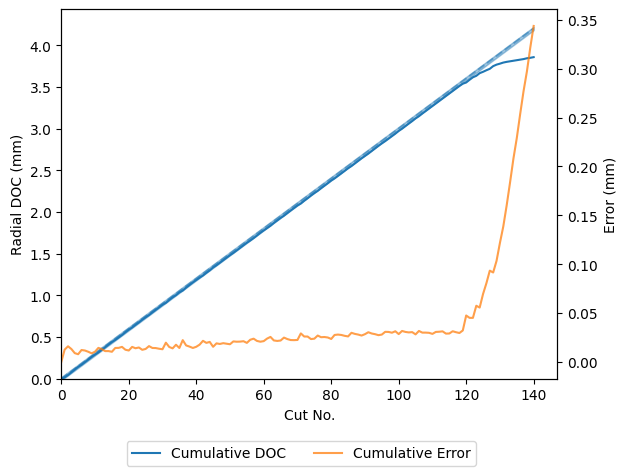

Test No: 21
Date: 2024-08-14
Data: ..\..\AE\Testing\24_08_14_weartest_D1.3_#1000
No. Files: AE-107 NC4-108


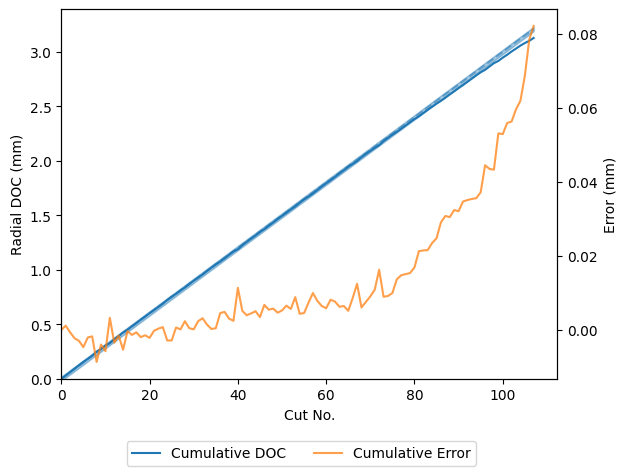

Test No: 22
Date: 2024-09-03
Data: ..\..\AE\Testing\24_09_03_weartest_D1.3_#1000
No. Files: AE-101 NC4-102


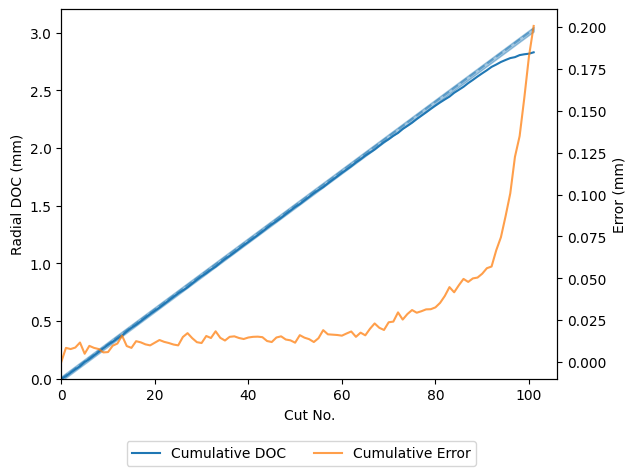

Test No: 23
Date: 2024-09-11
Data: ..\..\AE\Testing\24_09_11_weartest_D1.3_#1000
No. Files: AE-87 NC4-88


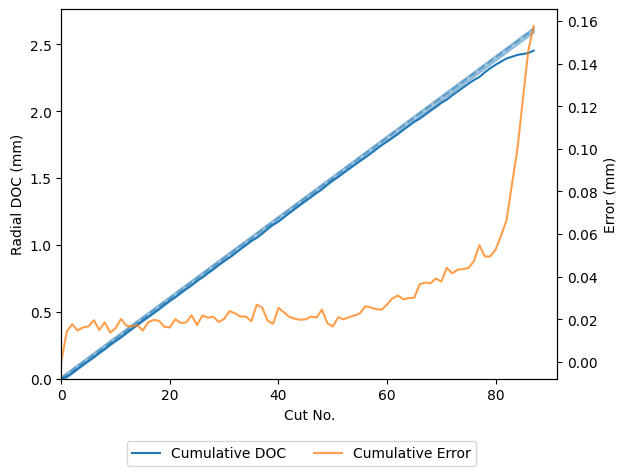

Test No: 24
Date: 2024-10-02
Data: ..\..\AE\Testing\24_10_02_weartest_D1.3_#1000
No. Files: AE-158 NC4-159


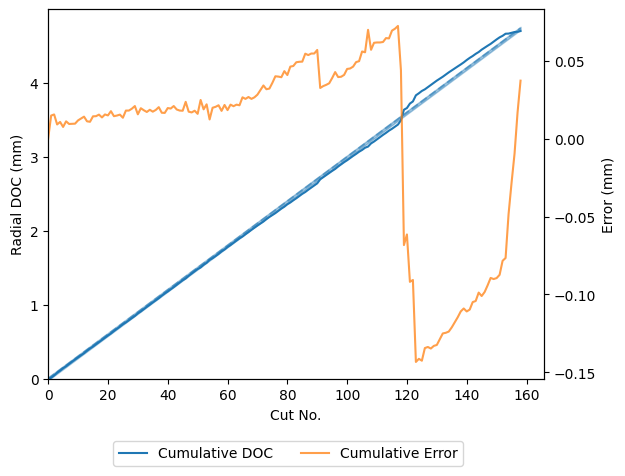

In [8]:
# If exp has probe data plot it
for exp in exps:
    print(exp)
    if exp.probe is not None:
        fig, ax = exp.probe.plot_probe_DOC()
        # ax2 = fig.get
        plt.show()

### Fix Probe

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

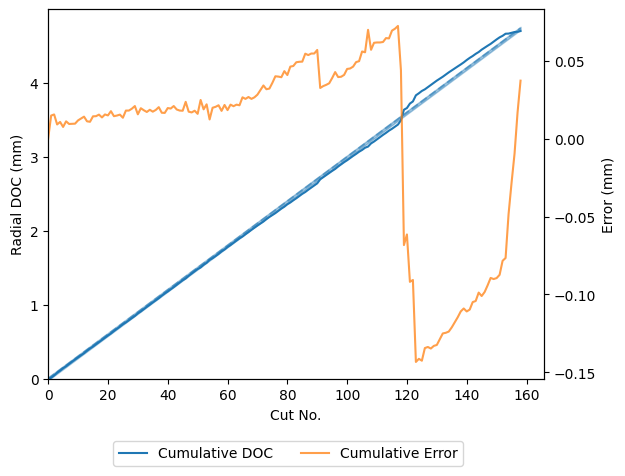

In [242]:
exps[-1].probe.plot_probe_DOC()

In [4]:
from src.probe.probe_data import readProbeCSV, probe_cumulative

In [10]:
probe_data = pd.read_csv(TESTING_DIR.joinpath(
    r'24_10_08_weartest_D1.3_#1000/241008-WEARTEST.csv'
), header=2,
)

probe_data.set_index('Cut No', inplace=True)
probe_data.reset_index(inplace=True)
probe_data['Cut No'] = probe_data.index
probe_data.set_index('Cut No', inplace=True)
probe_data

NC4 Radius   PROBE1   PROBE2   PROBE3   PROBE4  AVGPROBE  REFBORE-X  \
Cut No                                                                        
0           0.7385  18.2694  18.2695  18.2691  18.2692   18.2693   260.8983   
1           0.7356  18.3065  18.3076  18.2998  18.3049   18.3047   260.8920   
2           0.7350  18.3383  18.3381  18.3379  18.3374   18.3379   260.8904   
3           0.7344  18.3696  18.3578  18.3686  18.3687   18.3662   260.8890   
4           0.7335  18.4006  18.4009  18.4010  18.3982   18.4002   260.8879   
...            ...      ...      ...      ...      ...       ...        ...   
59          0.6596  19.9888  19.9854  19.9826  19.9811   19.9845   260.8893   
60          0.6551  20.0157  20.0157  20.0120  20.0160   20.0149   260.8885   
61          0.6535  20.0437  20.0433  20.0438  20.0451   20.0440   260.8893   
62          0.6518  20.0697  20.0691  20.0701  20.0687   20.0694   260.8937   
63          0.6507  20.0903  20.0886  20.0866  20.0922   20.0894   260.8916   

        REFBORE-Y  REFBORE-S  
Cut No                        
0         41.9908    25.0300  
1         41.9883    25.0299  
2         41.9851    25.0293  
3         41.9852    25.0295  
4         41.9850    25.0286  
...           ...        ...  
59        41.9859    25.0298  
60        41.9863    25.0289  
61        41.9860    25.0307  
62        41.9859    25.0310  
63        41.9859    25.0311  

[64 rows x 9 columns]

In [11]:
probe_data.to_csv(TESTING_DIR.joinpath(r'24_10_08_weartest_D1.3_#1000/241008-WEARTEST.csv'))

In [244]:
probe_data = pd.read_csv(TESTING_DIR.joinpath(
    r'24_10_02_weartest_D1.3_#1000/241002-WEARTEST-RemoveAnom.csv'
), header=2,
)

probe_data.set_index('Cut No', inplace=True)
probe_data

NC4 Radius   PROBE1   PROBE2   PROBE3   PROBE4  AVGPROBE  REFBORE-X  \
Cut No                                                                        
0.0         0.7341  13.1983  13.1989  13.1985  13.1989   13.1987   260.8976   
1.0         0.7326  13.2088  13.2085  13.2197  13.2189   13.2139   260.8920   
2.0         0.7310  13.2443  13.2431  13.2378  13.2475   13.2432   260.8894   
3.0         0.7298  13.2810  13.2787  13.2790  13.2800   13.2796   260.8874   
4.0         0.7296  13.3112  13.3111  13.2999  13.3099   13.3080   260.8858   
...            ...      ...      ...      ...      ...       ...        ...   
163.0       0.5636  17.8718  17.8659  17.8651  17.8659   17.8671   260.8916   
164.0       0.5550  17.8905  17.8735  17.8726  17.8714   17.8770   260.8914   
165.0       0.5338  17.8946  17.8888  17.8840  17.8859   17.8883   260.8950   
166.0       0.5161  17.8941  17.8922  17.8914  17.8903   17.8920   260.8936   
167.0       0.4816  17.9144  17.8976  17.9001  17.8936   17.9015   260.8928   

        REFBORE-Y  REFBORE-S  
Cut No                        
0.0       41.9940    25.0278  
1.0       41.9936    25.0272  
2.0       41.9914    25.0261  
3.0       41.9911    25.0249  
4.0       41.9915    25.0249  
...           ...        ...  
163.0     41.9866    25.0284  
164.0     41.9862    25.0278  
165.0     41.9862    25.0275  
166.0     41.9863    25.0293  
167.0     41.9863    25.0288  

[159 rows x 9 columns]

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

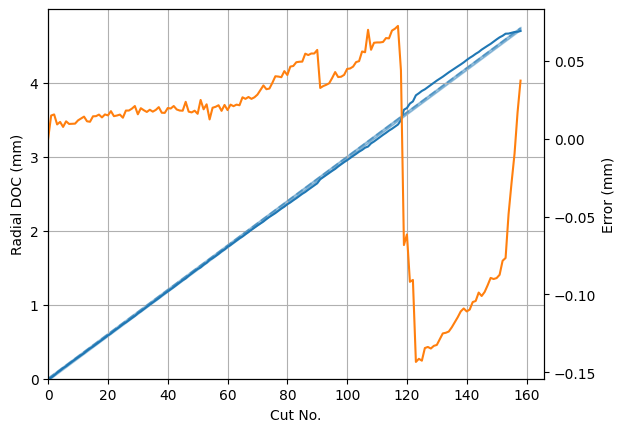

In [245]:
probe_cumulative(probe_data)

In [246]:
ix = [90, 92]
probe_data.loc[ix]

NC4 Radius   PROBE1   PROBE2   PROBE3   PROBE4  AVGPROBE  REFBORE-X  \
Cut No                                                                        
90.0        0.6902  15.8427  15.8415  15.8413  15.8419   15.8418   260.8934   
92.0        0.6872  15.8952  15.8973  15.8956  15.8968   15.8962   260.8904   

        REFBORE-Y  REFBORE-S  
Cut No                        
90.0      41.9882    25.0273  
92.0      41.9883    25.0268

In [247]:
diff = probe_data.loc[[90, 92]][['PROBE1', 'PROBE2', 'PROBE3', 'PROBE4', 'AVGPROBE']].diff()
avg = diff / (ix[1] - ix[0])
diff = diff - avg

In [248]:
probe_data.iloc[91:, 1:6] = probe_data.iloc[91:, 1:6] - diff.iloc[1:, :].to_numpy()

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

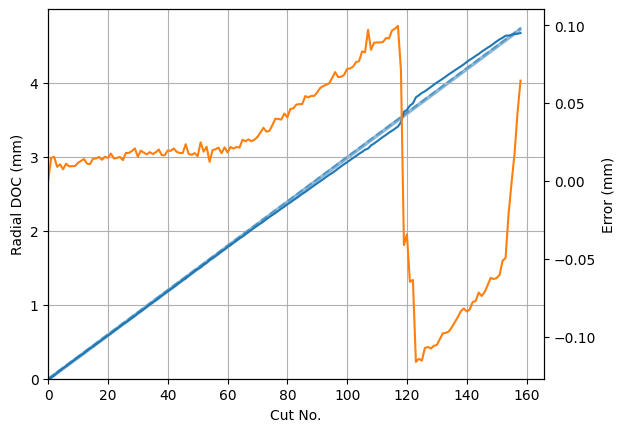

In [249]:
probe_cumulative(probe_data)

In [250]:
ix = [118, 120]
probe_data.loc[ix]

NC4 Radius    PROBE1   PROBE2    PROBE3    PROBE4  AVGPROBE  \
Cut No                                                                
118.0       0.6479  16.60925  16.6089  16.60955  16.60925   16.6092   
120.0       0.6447  16.66855  16.6678  16.66675  16.66775   16.6677   

        REFBORE-X  REFBORE-Y  REFBORE-S  
Cut No                                   
118.0    260.8913    41.9875    25.0274  
120.0    260.8952    41.9873    25.0280

In [251]:
diff = probe_data.loc[ix][['PROBE1', 'PROBE2', 'PROBE3', 'PROBE4', 'AVGPROBE']].diff()
avg = diff / (ix[1] - ix[0])
diff = diff - avg
diff = diff.iloc[1:, :].to_numpy()
diff

array([[0.02965, 0.02945, 0.0286 , 0.02925, 0.02925]])

In [252]:
iloc_ix = np.where(probe_data.index == ix[1])[0][0]
probe_data.iloc[iloc_ix:, 1:6] = probe_data.iloc[iloc_ix:, 1:6] - diff

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

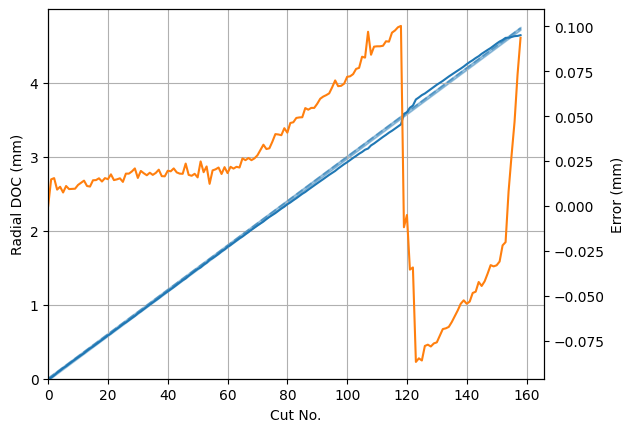

In [253]:
probe_cumulative(probe_data)

In [254]:
ix = [120, 125]
probe_data.loc[ix]

NC4 Radius   PROBE1    PROBE2    PROBE3   PROBE4  AVGPROBE  REFBORE-X  \
Cut No                                                                          
120.0       0.6447  16.6389  16.63835  16.63815  16.6385  16.63845   260.8952   
125.0       0.6365  16.7846  16.78105  16.78195  16.7746  16.78055   260.8949   

        REFBORE-Y  REFBORE-S  
Cut No                        
120.0     41.9873    25.0280  
125.0     41.9871    25.0276

In [255]:
diff = probe_data.loc[ix][['PROBE1', 'PROBE2', 'PROBE3', 'PROBE4', 'AVGPROBE']].diff()
avg = diff / (ix[1] - ix[0])
diff = diff - avg
diff = diff.iloc[1:, :].to_numpy()
diff

array([[0.11656, 0.11416, 0.11504, 0.10888, 0.11368]])

In [256]:
iloc_ix = np.where(probe_data.index == ix[1])[0][0]
probe_data.iloc[iloc_ix:, 1:6] = probe_data.iloc[iloc_ix:, 1:6] - diff

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

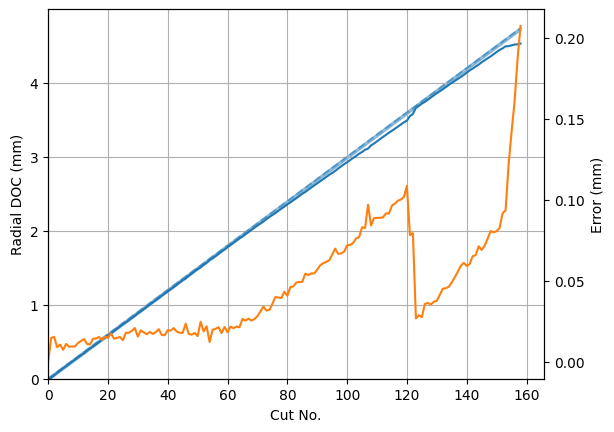

In [257]:
probe_cumulative(probe_data)

In [258]:
ix = [126, 128]
probe_data.loc[ix]

NC4 Radius    PROBE1    PROBE2    PROBE3    PROBE4  AVGPROBE  \
Cut No                                                                 
126.0       0.6359  16.67954  16.69169  16.69301  16.69632  16.69007   
128.0       0.6334  16.74984  16.74999  16.74761  16.75472  16.75047   

        REFBORE-X  REFBORE-Y  REFBORE-S  
Cut No                                   
126.0    260.8938    41.9874    25.0285  
128.0    260.8921    41.9874    25.0281

In [259]:
diff = probe_data.loc[ix][['PROBE1', 'PROBE2', 'PROBE3', 'PROBE4', 'AVGPROBE']].diff()
avg = diff / (ix[1] - ix[0])
diff = diff - avg
diff = diff.iloc[1:, :].to_numpy()
diff

array([[0.03515, 0.02915, 0.0273 , 0.0292 , 0.0302 ]])

In [260]:
iloc_ix = np.where(probe_data.index == ix[1])[0][0]
probe_data.iloc[iloc_ix:, 1:6] = probe_data.iloc[iloc_ix:, 1:6] - diff

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

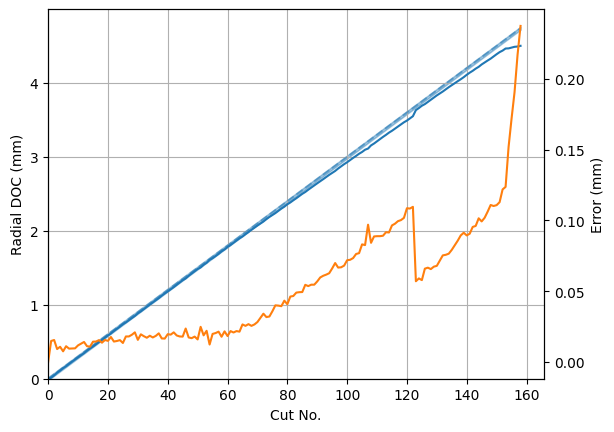

In [261]:
probe_cumulative(probe_data)

In [262]:
ix = [129, 132]
probe_data.loc[ix]

NC4 Radius    PROBE1    PROBE2    PROBE3    PROBE4  AVGPROBE  \
Cut No                                                                 
129.0       0.6317  16.74169  16.74914  16.75111  16.75462  16.74907   
132.0       0.6221  16.82059  16.83434  16.83401  16.83792  16.83167   

        REFBORE-X  REFBORE-Y  REFBORE-S  
Cut No                                   
129.0    260.8912    41.9875    25.0267  
132.0    260.8932    41.9875    25.0276

In [263]:
diff = probe_data.loc[ix][['PROBE1', 'PROBE2', 'PROBE3', 'PROBE4', 'AVGPROBE']].diff()
avg = diff / (ix[1] - ix[0])
diff = diff - avg
diff = diff.iloc[1:, :].to_numpy()
diff

array([[0.0526    , 0.0568    , 0.05526667, 0.05553333, 0.05506667]])

In [264]:
iloc_ix = np.where(probe_data.index == ix[1])[0][0]
probe_data.iloc[iloc_ix:, 1:6] = probe_data.iloc[iloc_ix:, 1:6] - diff

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Cut No.', ylabel='Radial DOC (mm)'>)

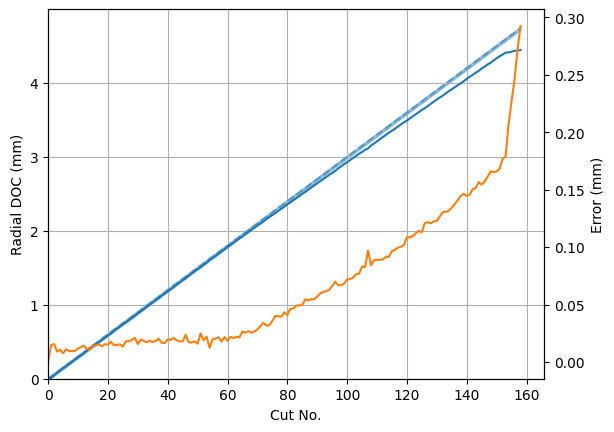

In [265]:
probe_cumulative(probe_data)

In [266]:
probe_data.reset_index(inplace=True)

In [270]:
probe_data['Cut No'] = probe_data.index
probe_data

Cut No  NC4 Radius    PROBE1    PROBE2     PROBE3     PROBE4   AVGPROBE  \
0         0      0.7341  13.19830  13.19890  13.198500  13.198900  13.198700   
1         1      0.7326  13.20880  13.20850  13.219700  13.218900  13.213900   
2         2      0.7310  13.24430  13.24310  13.237800  13.247500  13.243200   
3         3      0.7298  13.28100  13.27870  13.279000  13.280000  13.279600   
4         4      0.7296  13.31120  13.31110  13.299900  13.309900  13.308000   
..      ...         ...       ...       ...        ...        ...        ...   
154     154      0.5636  17.61159  17.60844  17.611743  17.615587  17.611703   
155     155      0.5550  17.63029  17.61604  17.619243  17.621087  17.621603   
156     156      0.5338  17.63439  17.63134  17.630643  17.635587  17.632903   
157     157      0.5161  17.63389  17.63474  17.638043  17.639987  17.636603   
158     158      0.4816  17.65419  17.64014  17.646743  17.643287  17.646103   

     REFBORE-X  REFBORE-Y  REFBORE-S  
0     260.8976    41.9940    25.0278  
1     260.8920    41.9936    25.0272  
2     260.8894    41.9914    25.0261  
3     260.8874    41.9911    25.0249  
4     260.8858    41.9915    25.0249  
..         ...        ...        ...  
154   260.8916    41.9866    25.0284  
155   260.8914    41.9862    25.0278  
156   260.8950    41.9862    25.0275  
157   260.8936    41.9863    25.0293  
158   260.8928    41.9863    25.0288  

[159 rows x 10 columns]

In [271]:
probe_data.to_csv(TESTING_DIR.joinpath(r'24_10_02_weartest_D1.3_#1000/241002-WEARTEST-FIXED.csv'))

### Probe for Classification

In [12]:
exps[6].probe.probeData

NC4 Radius   PROBE1   PROBE2   PROBE3   PROBE4  AVGPROBE  REFBORE-X  \
Cut No                                                                        
0.0         0.6673  12.0714  12.0706  12.0718  12.0713    0.0000        0.0   
1.0         0.6658  12.0712  12.0705  12.0718  12.0708   -0.0002       -1.9   
2.0         0.6601  12.0887  12.0886  12.0909  12.0892    0.0181       -4.2   
3.0         0.6591  12.1183  12.1188  12.1204  12.1172    0.0474       -5.9   
4.0         0.6590  12.1474  12.1460  12.1481  12.1449    0.0753       -7.2   
...            ...      ...      ...      ...      ...       ...        ...   
137.0       0.6371  16.1046  16.0869  16.0957  16.0834    4.0213       -6.0   
138.0       0.6345  16.1135  16.1043  16.1240  16.1233    4.0450       -7.2   
139.0       0.6243  16.1157  16.1225  16.1280  16.1412    4.0556       -7.8   
140.0       0.6068  16.1478  16.1495  16.1550  16.1505    4.0794       -2.4   
141.0       0.6025  16.1793  16.1537  16.1585  16.1844    4.0977       -4.9   

        REFBORE-Y  REFBORE-S  PROBEDIFF  
Cut No                                   
0.0           0.0    24.9961     0.0000  
1.0           0.9    24.9984    -0.0002  
2.0           0.6    24.9984     0.0183  
3.0           0.5    24.9985     0.0293  
4.0           1.2    24.9979     0.0279  
...           ...        ...        ...  
137.0         3.9    24.9999     0.0340  
138.0         4.1    25.0001     0.0237  
139.0         4.0    24.9996     0.0106  
140.0         4.6    25.0002     0.0238  
141.0         4.9    25.0001     0.0183  

[142 rows x 10 columns]

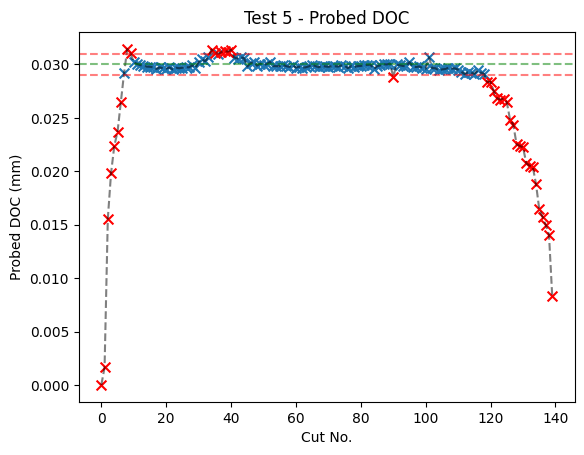

In [263]:
i = 4
doc = 0.03
tol = 0.001

y_smooth = exps[i].probe.probeData['PROBEDIFF'].values
x = np.arange(len(y_smooth))
y_smooth = _smooth(exps[i].probe.probeData['PROBEDIFF'].values, 11)

tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y_smooth]
tol_bool = np.array(tol_bool).astype(bool)

in_tol = y_smooth.copy()
in_tol[tol_bool] = np.nan

out_tol = y_smooth.copy()
out_tol[~tol_bool] = np.nan

fig, ax = plt.subplots()
ax.scatter(x, in_tol, color='C0', marker='x', s=50)
ax.scatter(x, out_tol, color='r', marker='x', s=50)
ax.plot(x, y_smooth, color='k', alpha=0.5, linestyle='--')

ax.axhline(doc, color='g', ls='--', alpha=0.5)
ax.axhline(doc - tol, color='r', ls='--', alpha=0.5)
ax.axhline(doc + tol, color='r', ls='--', alpha=0.5)

ax.set_xlabel('Cut No.')
ax.set_ylabel('Probed DOC (mm)')
ax.set_title(f'Test {i + 1} - Probed DOC')

crossing = []
for ix in x[tol_bool]:
    if ix - 1 not in x[tol_bool]:
        crossing.append(ix)
    elif ix + 1 not in x[tol_bool]:
        crossing.append(ix)


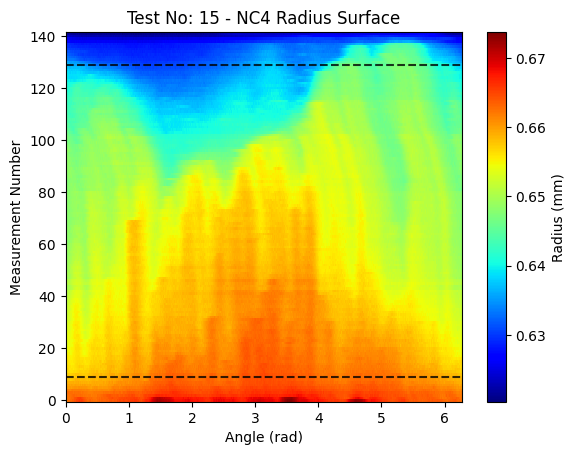

In [257]:
fig, ax = exps[i].nc4.plot_surf()
ax.axhline(crossing[1], color='k', ls='--', alpha=0.8)
ax.axhline(crossing[2], color='k', ls='--', alpha=0.8)


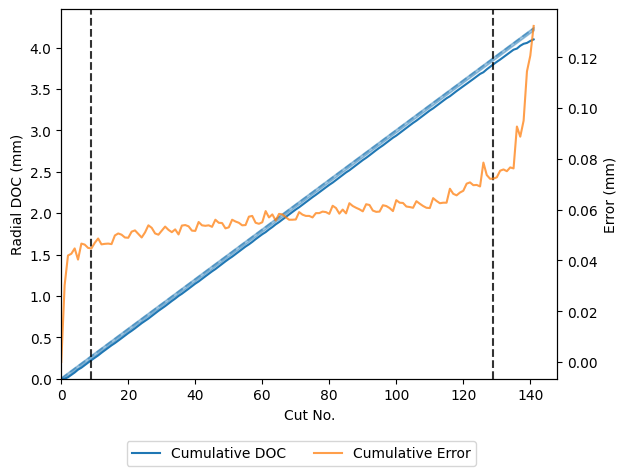

In [258]:
fig, ax = exps[i].probe.plot_probe_DOC()
ax.axvline(crossing[1], color='k', ls='--', alpha=0.8)
ax.axvline(crossing[2], color='k', ls='--', alpha=0.8)

In [70]:
%matplotlib inline

### NC4 - Spiral Scans

In [223]:
NOM_DIA = 1.3
FEEDRATE = 2
RPM = 60
FS = 50_000
YOFFSET = 0.03
CALFEEDRATE = 60

SCPath = CODE_DIR.joinpath(
    r'src/reference/NC4_BJD_SCurve_2024_05_30_14_17_12-Ch0-50kHz.tdms'
)
assert SCPath.exists(), "SCurve calibration file not found."

In [224]:
expSprialScans = []
for exp in exps[5:]:
    expSprialScans.append(processExpSprialScans(
        exp,
        SCPath,
        NOM_DIA,
        FEEDRATE,
        RPM,
        FS,
        YOFFSET,
        CALFEEDRATE,
    ))

Processing Spiral Scans: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


In [225]:
exp_sprial_mean = []
for exp_sc in expSprialScans:
    mean_rad = []
    for sc in exp_sc:
        z = np.arange(0, len(sc.scanMat)) * FEEDRATE / 60
        z_lower_ix = np.argmin(np.abs(z - 1.0))
        z_upper_ix = np.argmin(np.abs(z - 5))
        sc_data = sc.scanMat[z_lower_ix:z_upper_ix, :].flatten()
        sc_data = _smooth(sc_data, win=121)

        
        mean_rad.append(np.median(sc_data))
    exp_sprial_mean.append(mean_rad)

102
104
104
114
128
119
77


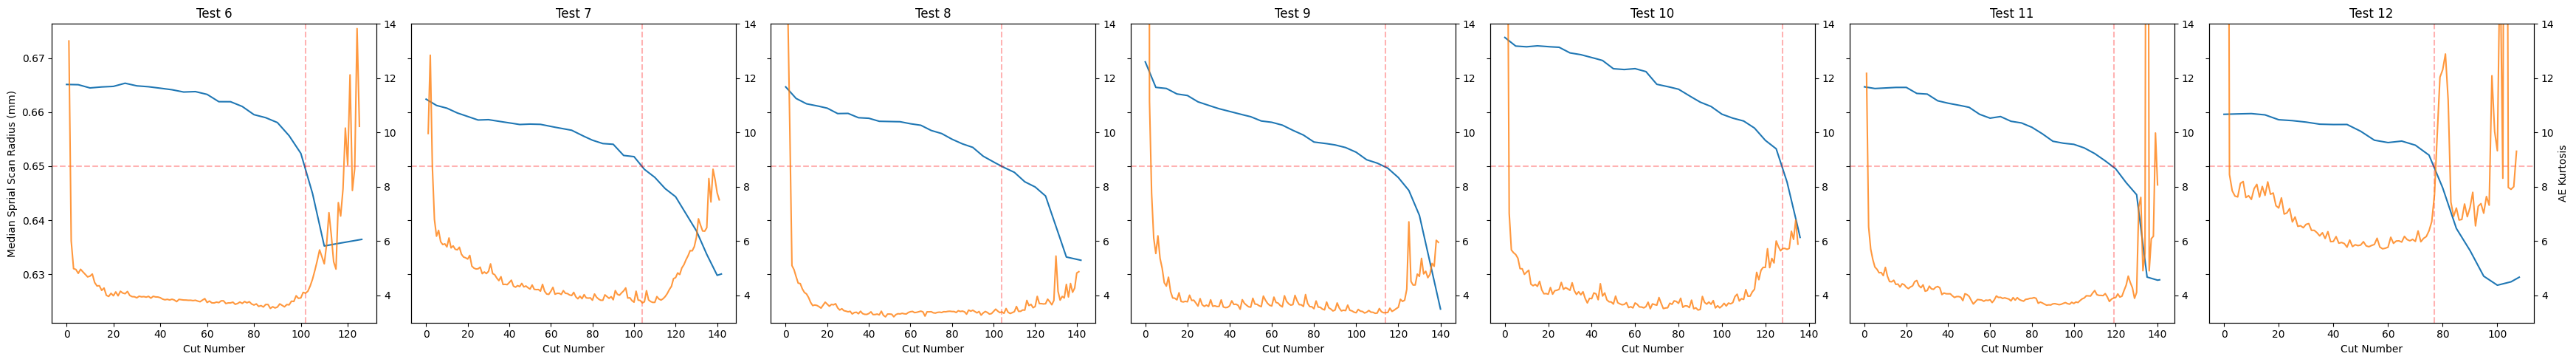

In [226]:
trig_idx = []

fig, ax = plt.subplots(1, len(exp_sprial_mean), figsize=(len(exp_sprial_mean) * 5, 5), sharey=True)
for i, c in enumerate(exp_sprial_mean):
    x = np.arange(0, len(c)) * 5
    f = interpolate.interp1d(x, c, fill_value='extrapolate')

    xnew = np.arange(0, len(exps[i+5].features['Kurtosis']) + 1)
    ynew = f(xnew)

    # ax[i].plot(x, c)
    ax[i].plot(xnew, ynew)
    ax[i].set_title(f"Test {i+6}")

    trig = 0.65
    ax[i].axhline(trig, color='r', linestyle='--', alpha=0.3)
    idx = np.where(np.array(ynew) < trig)[0][0]
    print(idx) 
    ax[i].axvline(idx, color='r', linestyle='--', alpha=0.3)
    trig_idx.append(idx)

    ax2 = ax[i].twinx()
    ax2.plot(exps[i+5].features['Kurtosis'], color='C1', alpha=0.8)
    ax2.set_ylim(3, 14)

    ax[i].set_xlabel('Cut Number')
    ax[0].set_ylabel('Median Sprial Scan Radius (mm)')
ax2.set_ylabel('AE Kurtosis')

fig.tight_layout()

## PROBE VS AE

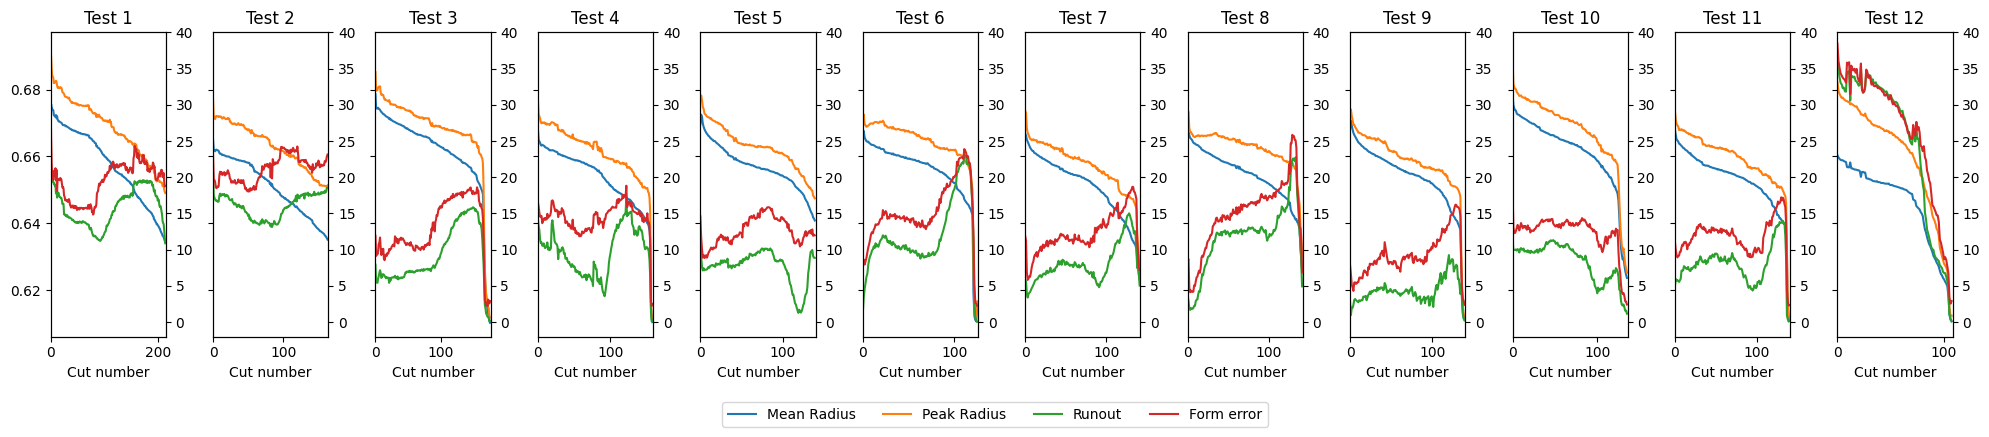

In [13]:
fig, ax = plt.subplots(1, len(exps), figsize=(5 * 4, 4), sharey=True)
for i, exp in enumerate(exps):
    ax[i].plot(exp.features['Mean radius'], label='Mean Radius')
    ax[i].plot(exp.features['Peak radius'], label='Peak Radius')
    ax2 = ax[i].twinx()
    ax2.plot(exp.features['Runout'] * 1000, 'C2', label='Runout')
    ax2.plot(exp.features['Form error'] * 1000, 'C3', label='Form error')
    ax[i].set_xlim(0, len(exp.features))
    ax2.set_ylim(-2, 40)

    ax[i].set_title(f"Test {i + 1}")
    ax[i].set_xlabel('Cut number')

# ax[0].set_ylabel(f'AE Feature - {feat}')
# ax2.set_ylabel('Probed DOC (um)')
l1, lab1 = ax[-1].get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()

fig.legend(l1 + l2, lab1 + lab2, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

fig.tight_layout()

(2.0, 20.0)

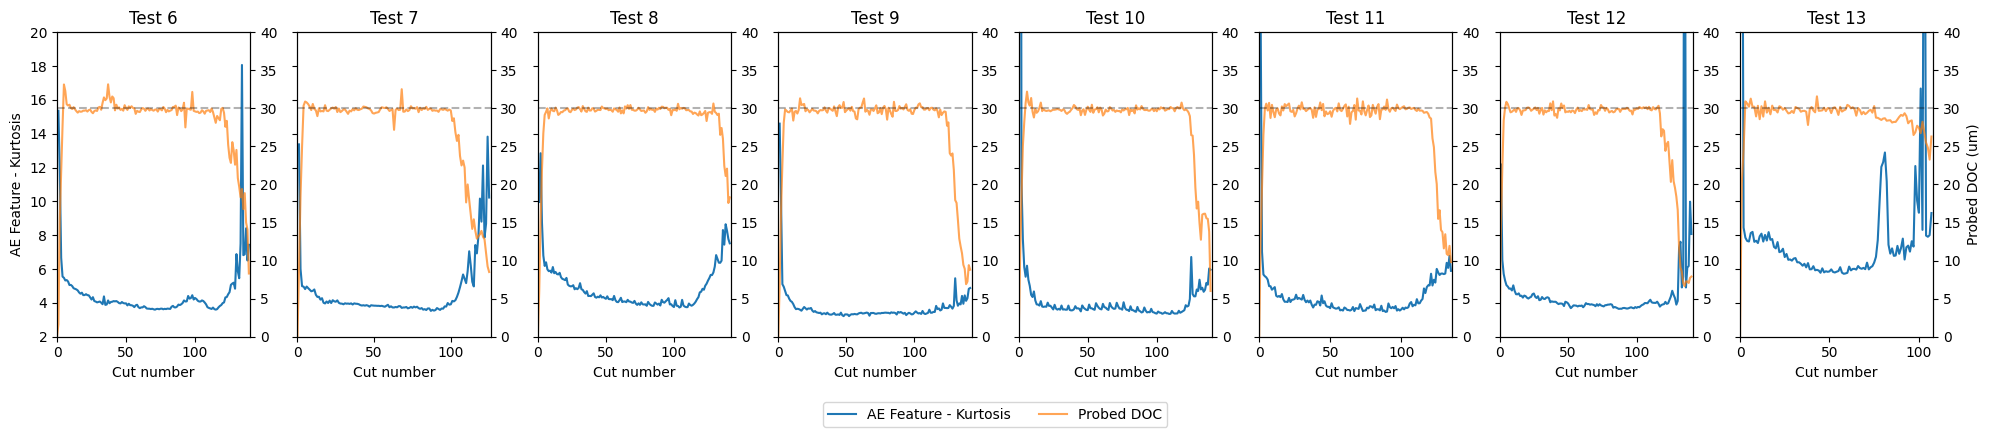

In [19]:
def plotProbeVSAEFeat(feat):
    _exps = exps[4:]
    fig, ax = plt.subplots(1, len(_exps), figsize=(5 * 4, 4), sharey=True)
    for i, exp in enumerate(_exps):
        ax[i].plot(exp.features[feat], label=f'AE Feature - {feat}')
        if exp.probe is not None:
            ax2 = ax[i].twinx()
            ax2.plot(_smooth(exp.features['Probe diff'] * 1000, 5), 'C1', alpha=0.7, label='Probed DOC')
            ax2.axhline(exp.probe.doc * 1000, color='k', linestyle='--', alpha=0.3)
            ax2.set_ylim(0, 40)
        ax[i].set_xlim(0, len(exp.features))

        ax[i].set_title(f"Test {i + 6}")
        ax[i].set_xlabel('Cut number')

    ax[0].set_ylabel(f'AE Feature - {feat}')
    ax2.set_ylabel('Probed DOC (um)')

    l1 = ax[-1].get_lines()[0]
    l2 = ax2.get_lines()[0]
    lab1 = l1.get_label()
    lab2 = l2.get_label()
    fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    fig.tight_layout()
    return fig, ax

feat = 'Kurtosis'
fig, ax = plotProbeVSAEFeat(feat)
# for _ax, ix in zip(ax[5:], trig_idx):
#     _ax.axvline(ix, color='r', linestyle='--', alpha=0.3)
ax[0].set_ylim(2, 20)

In [9]:
for i, st_i in enumerate(np.arange(0, 1_000, 10)):
    print(f'Bin {i} - {st_i} to {st_i + 10} kHz')


Bin 0 - 0 to 10 kHz
Bin 1 - 10 to 20 kHz
Bin 2 - 20 to 30 kHz
Bin 3 - 30 to 40 kHz
Bin 4 - 40 to 50 kHz
Bin 5 - 50 to 60 kHz
Bin 6 - 60 to 70 kHz
Bin 7 - 70 to 80 kHz
Bin 8 - 80 to 90 kHz
Bin 9 - 90 to 100 kHz
Bin 10 - 100 to 110 kHz
Bin 11 - 110 to 120 kHz
Bin 12 - 120 to 130 kHz
Bin 13 - 130 to 140 kHz
Bin 14 - 140 to 150 kHz
Bin 15 - 150 to 160 kHz
Bin 16 - 160 to 170 kHz
Bin 17 - 170 to 180 kHz
Bin 18 - 180 to 190 kHz
Bin 19 - 190 to 200 kHz
Bin 20 - 200 to 210 kHz
Bin 21 - 210 to 220 kHz
Bin 22 - 220 to 230 kHz
Bin 23 - 230 to 240 kHz
Bin 24 - 240 to 250 kHz
Bin 25 - 250 to 260 kHz
Bin 26 - 260 to 270 kHz
Bin 27 - 270 to 280 kHz
Bin 28 - 280 to 290 kHz
Bin 29 - 290 to 300 kHz
Bin 30 - 300 to 310 kHz
Bin 31 - 310 to 320 kHz
Bin 32 - 320 to 330 kHz
Bin 33 - 330 to 340 kHz
Bin 34 - 340 to 350 kHz
Bin 35 - 350 to 360 kHz
Bin 36 - 360 to 370 kHz
Bin 37 - 370 to 380 kHz
Bin 38 - 380 to 390 kHz
Bin 39 - 390 to 400 kHz
Bin 40 - 400 to 410 kHz
Bin 41 - 410 to 420 kHz
Bin 42 - 420 to 430 kH

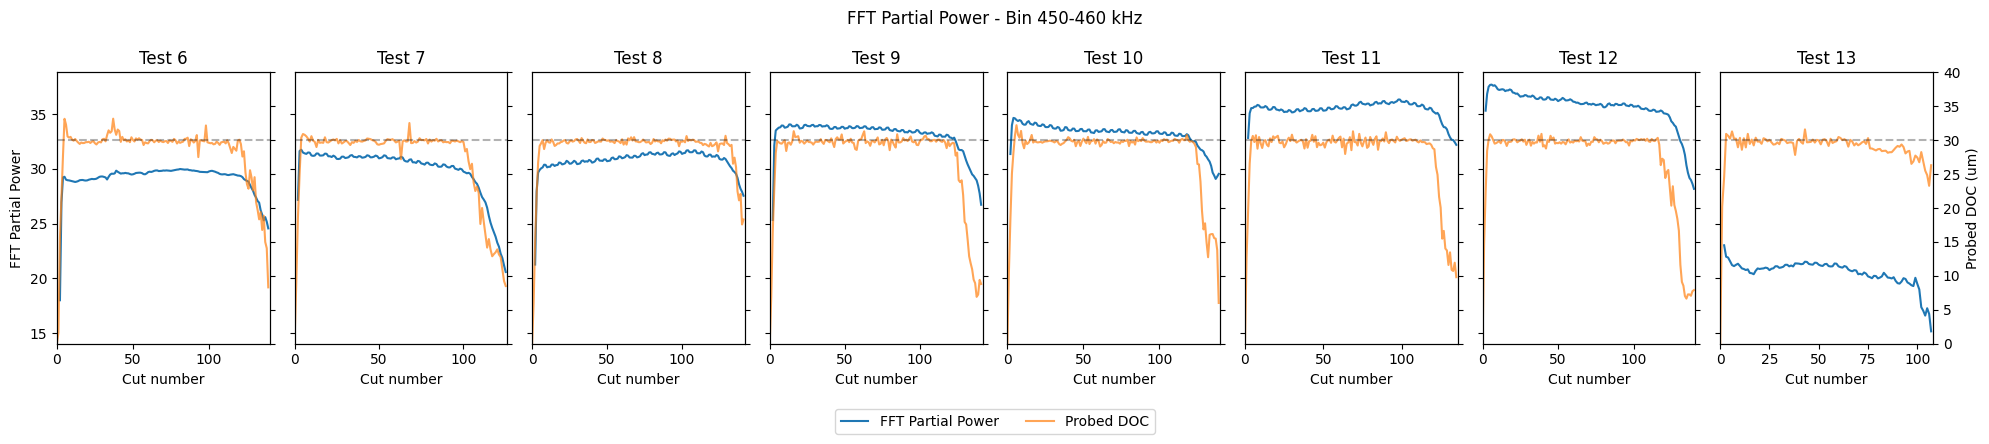

In [10]:
def plotProbeVSFFT(freq):
    _exps = exps[4:]
    fig, ax = plt.subplots(1, len(_exps), figsize=(5 * 4, 4), sharey=True)
    for i, exp in enumerate(_exps):
        f = np.array(exp.ae.fft[1000])
        # avg over 10kHz
        f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
        f = f.T
        f = np.concatenate(([np.NaN], f[freq]))

        ax[i].plot(_smooth(f, 3), label=f'FFT Partial Power')
        if exp.probe is not None:
            ax2 = ax[i].twinx()
            ax2.plot(_smooth(exp.features['Probe diff'] * 1000, 5), 'C1', alpha=0.7, label='Probed DOC')
            ax2.axhline(exp.probe.doc * 1000, color='k', linestyle='--', alpha=0.3)
            ax2.set_ylim(0, 40)
        ax[i].set_xlim(0, len(exp.features))

        ax[i].set_title(f"Test {i + 6}")
        ax[i].set_xlabel('Cut number')
        if i != len(_exps) - 1:
            ax2.set_yticklabels([])

    ax[0].set_ylabel(f'FFT Partial Power')
    ax2.set_ylabel('Probed DOC (um)')

    l1 = ax[-1].get_lines()[0]
    l2 = ax2.get_lines()[0]
    lab1 = l1.get_label()
    lab2 = l2.get_label()
    fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    fig.tight_layout()
    return fig, ax

freq = 45
fig, ax = plotProbeVSFFT(freq)
fig.suptitle(f'FFT Partial Power - Bin {freq * 10}-{(freq*10) + 10} kHz')
# for _ax, ix in zip(ax[5:], trig_idx):
#     _ax.axvline(ix, color='r', linestyle='--', alpha=0.3)
fig.tight_layout()

Max correlation: 0.541 at 760 kHz
Max correlation: 0.879 at 910 kHz
Max correlation: 0.479 at 50 kHz
Max correlation: 0.679 at 890 kHz
Max correlation: 0.904 at 930 kHz
Max correlation: 0.889 at 260 kHz
Max correlation: 0.916 at 780 kHz
Max correlation: 0.897 at 70 kHz


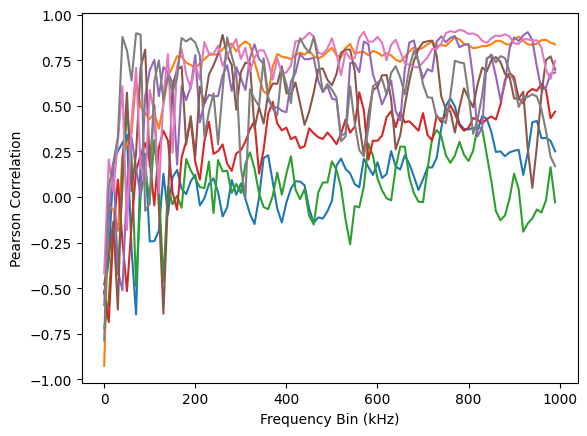

In [51]:
_exps = exps[4:]
fig, ax = plt.subplots()
for exp in _exps:
    # correlation between frequency bins and probe data
    f = np.array(exp.ae.fft[1000])
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T
    # p = exp.probe.probeData['PROBEDIFF'][1:]
    p = exp.features['Mean radius'][1:]
    fbin = np.arange(0, 1_000, 10)
    c = np.corrcoef(f, p)

    ax.plot(fbin, c[-1, :-1])
    ax.set_ylabel('Pearson Correlation')
    ax.set_xlabel('Frequency Bin (kHz)')

    # max correlation

    max_corr = np.max(c[-1, :-1])
    max_corr_ix = np.argmax(c[-1, :-1])

    print(f'Max correlation: {max_corr:.3f} at {max_corr_ix * 10} kHz')


## Correlation Matrix

In [11]:
from seaborn import heatmap

['Freq 900 kHz' 'Mean radius' 'Peak radius' 'Runout' 'Form error'
 'Avg probe' 'Probe diff']


Text(45.722222222222214, 0.5, 'Frequency Bin (kHz)')

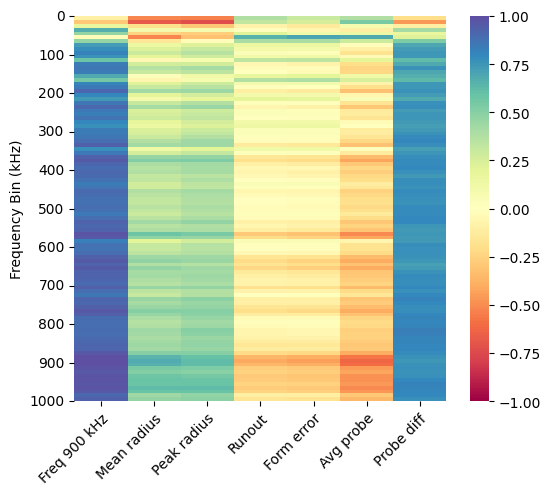

In [156]:
f = np.array(exp.ae.fft[1000])
# avg over 10kHz
f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
f = f.T
t = exp.features.drop(columns='Radius diff')
t = t.iloc[1:, 8:]
labs = t.columns
print(labs.values)
c = np.corrcoef(f, t.T)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax = heatmap(c[100:, :100].T, 
             vmax=1, vmin=-1,
             xticklabels=t.columns,
             ax=ax,
             cmap='Spectral'
             )
ax.set_yticks(np.arange(0, 110, 10))
ax.set_yticklabels(np.arange(0, 110, 10) * 10)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Frequency Bin (kHz)')

[Text(0.5, 0, 'Mean radius'),
 Text(1.5, 0, 'Peak radius'),
 Text(2.5, 0, 'Runout'),
 Text(3.5, 0, 'Form error'),
 Text(4.5, 0, 'Avg probe'),
 Text(5.5, 0, 'Probe diff')]

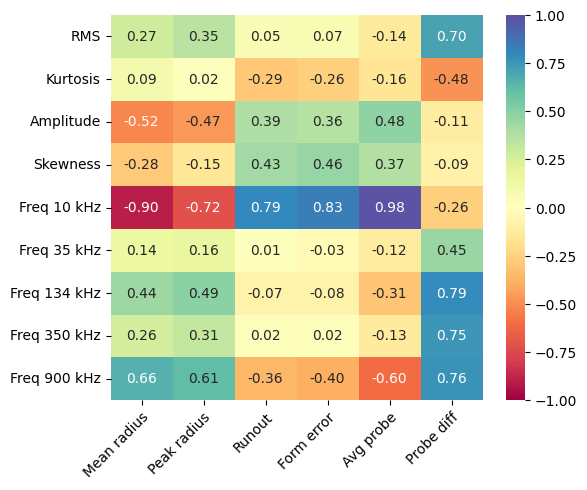

In [153]:
exp = exps[7]

c = exp.features.drop(columns='Radius diff')
f = np.array(exp.ae.fft[1000])
# avg over 10kHz
f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
f = f.T

# normalise freq power between 0 and 1
f_vec = f[35]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
# f = _smooth(f, 3)
c['Freq 350 kHz'] = f_vec

f_vec = f[90]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
# f = _smooth(f, 3)
c['Freq 900 kHz'] = f_vec
c.insert(8, 'Freq 900 kHz', c.pop('Freq 900 kHz'))
# c['Avg ']
# c['Probe DOC'] = exp.probe.probeData['Probe diff']

c = c.corr()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax = heatmap(c.iloc[:9, 9:],
             annot=True, 
             fmt=".2f",
             vmin=-1, vmax=1,
             cmap='Spectral',
             ax=ax,
             )
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

## Rolling RMS Surface Plot

In [6]:
exp = exps[-1]

(0.0, 20.9329035)

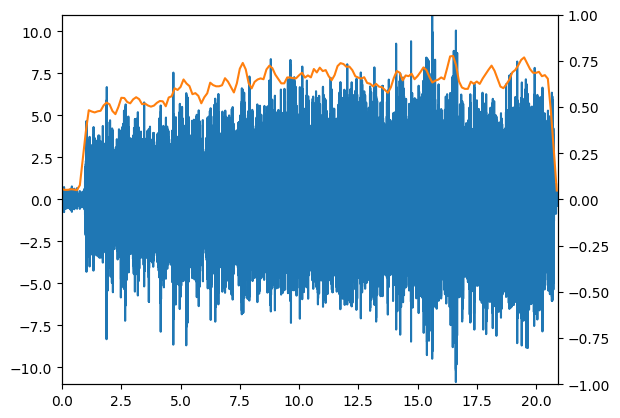

In [7]:
sig = exp.ae.readAE(0)

sigSquared = np.square(sig)
winLen = 250_000
# pad signal to make divisible by window size
padLen = winLen - len(sigSquared) % winLen
sigSquared = np.pad(sigSquared, (0, padLen), constant_values=np.NaN)
sigWindowed = sigSquared.reshape(-1, winLen)

rms = np.sqrt(np.nanmean(sigWindowed, axis=1))
rms = _smooth(rms, 3)

t_sig = np.arange(0, len(sig)) * 1/2_000_000
t_rms = np.arange(0, len(rms)) * 1/(2_000_000/winLen)

fig, ax = plt.subplots()
ax.plot(t_sig, sig)
ax2 = ax.twinx()
ax2.plot(t_rms, rms, 'C1')

ax.set_ylim(-11, 11)
ax2.set_ylim(-1, 1)
ax.set_xlim(t_sig[0], t_sig[-1])

In [88]:
winLen = 250_000
rmsExps = []

for i, exp in enumerate(exps):
    rms = []
    maxLen = 0

    for i in tqdm(range(0, len(exp.ae._files) - 1)):
        sig = exp.ae.readAE(i)
        sigSquared = np.square(sig)
        padLen = winLen - len(sigSquared) % winLen
        sigSquared = np.pad(sigSquared, (0, padLen), constant_values=np.NaN)
        sigWindowed = sigSquared.reshape(-1, winLen)
        r = np.sqrt(np.nanmean(sigWindowed, axis=1))
        rms.append(r)

        if len(r) > maxLen:
            maxLen = len(r)

    for i, r in enumerate(rms):
        r = np.pad(r, (0, maxLen - len(r)), constant_values=np.NaN)
        rms[i] = r

    rms = np.concatenate(rms, axis=0).reshape(-1, maxLen)
    print(rms.shape)
    rmsExps.append(rms)

100%|██████████| 212/212 [07:01<00:00,  1.99s/it]


(212, 170)


100%|██████████| 162/162 [07:05<00:00,  2.63s/it]


(162, 170)


100%|██████████| 175/175 [08:08<00:00,  2.79s/it]


(175, 170)


100%|██████████| 157/157 [05:32<00:00,  2.12s/it]


(157, 170)


100%|██████████| 138/138 [04:30<00:00,  1.96s/it]


(138, 169)


100%|██████████| 124/124 [04:12<00:00,  2.04s/it]


(124, 169)


100%|██████████| 140/140 [04:48<00:00,  2.06s/it]


(140, 169)


100%|██████████| 140/140 [04:37<00:00,  1.98s/it]


(140, 170)


100%|██████████| 138/138 [05:01<00:00,  2.19s/it]


(138, 169)


100%|██████████| 134/134 [04:44<00:00,  2.13s/it]


(134, 170)


100%|██████████| 139/139 [04:49<00:00,  2.08s/it]


(139, 171)


100%|██████████| 106/106 [03:47<00:00,  2.14s/it]


(106, 170)


100%|██████████| 100/100 [03:36<00:00,  2.16s/it]

(100, 170)


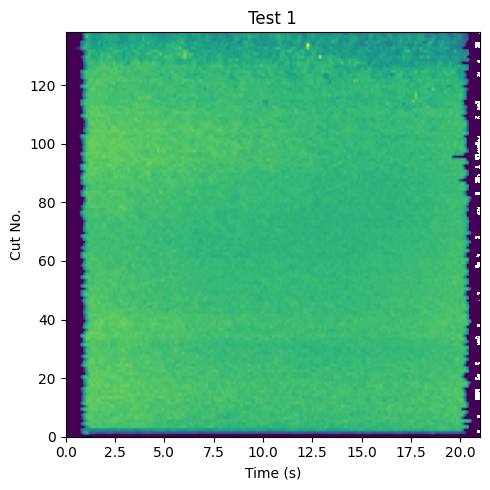

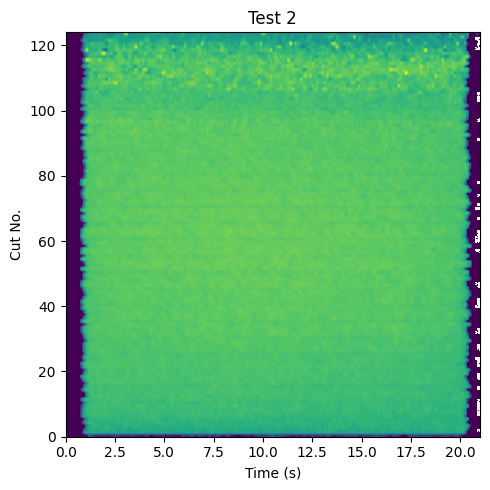

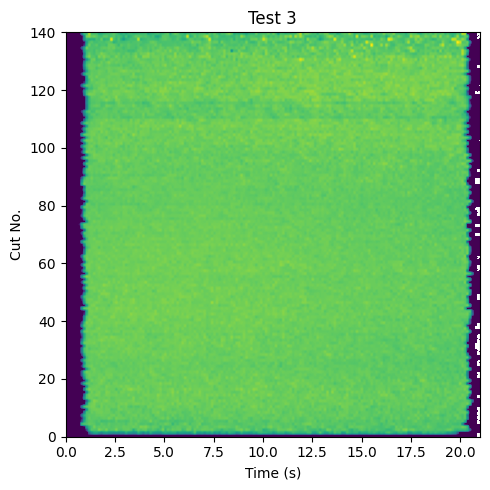

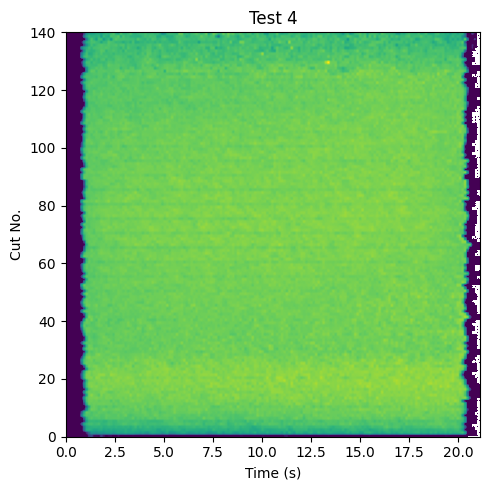

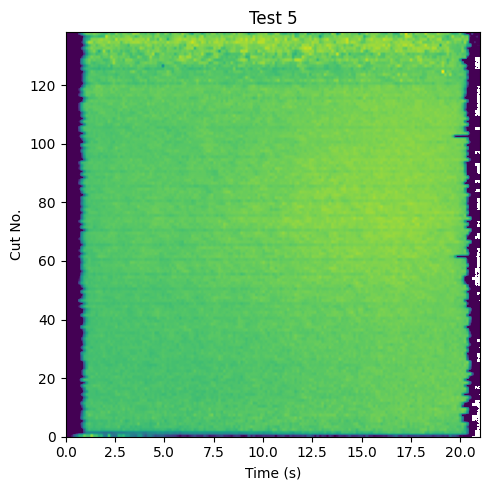

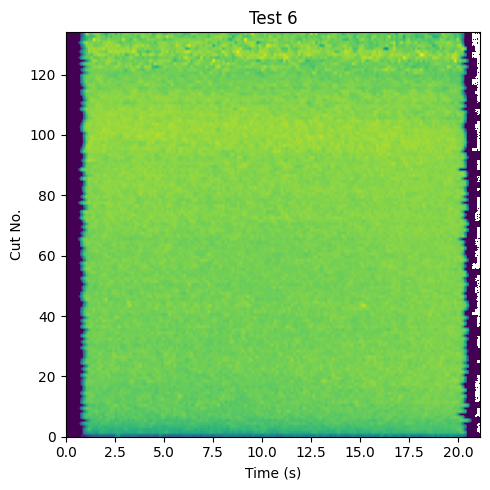

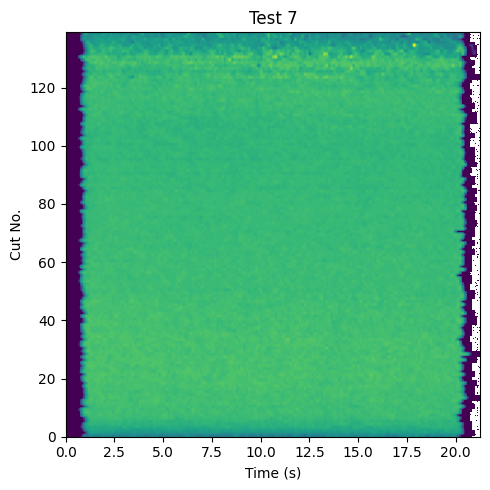

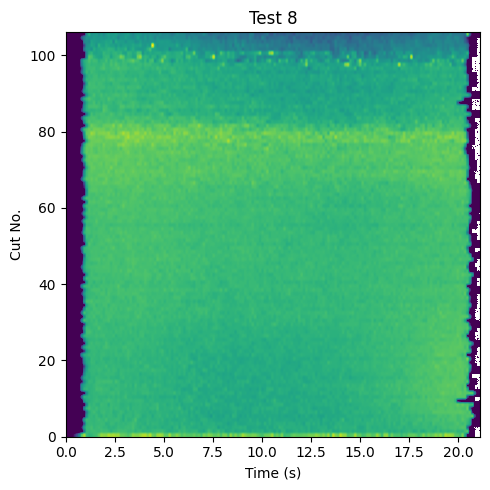

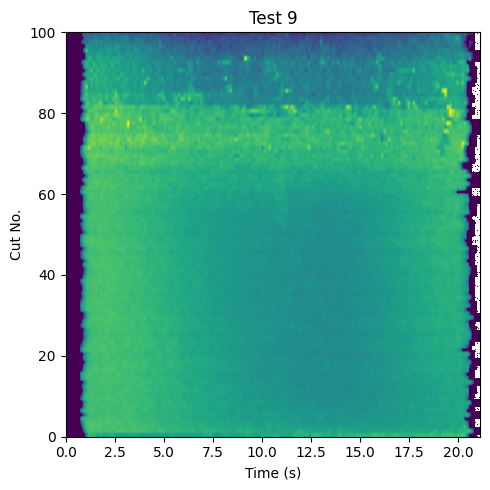

In [111]:
import matplotlib.colors as colors

for i, rms in enumerate(rmsExps[4:]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    rms[np.isnan(rms)] = 0
    t_rms = np.arange(0, rms.shape[1]) * 1/(2_000_000/winLen)
    im = ax.imshow(rms,
                      origin='lower',
                      aspect='auto',
                      cmap='viridis',
                    #   vmin=0.1,
                    #   vmax=3,
                      norm=colors.LogNorm(vmin=0.1, vmax=np.nanmax(rms)),
                      extent=[0, t_rms[-1], 0, rms.shape[0]],
                      )
    ax.set_title(f'Test {i + 1}')
    # if i > 3:
    ax.set_xlabel('Time (s)')
    # if i == 0:
    ax.set_ylabel('Cut No.')
    # fig.colorbar(im)
    fig.tight_layout()

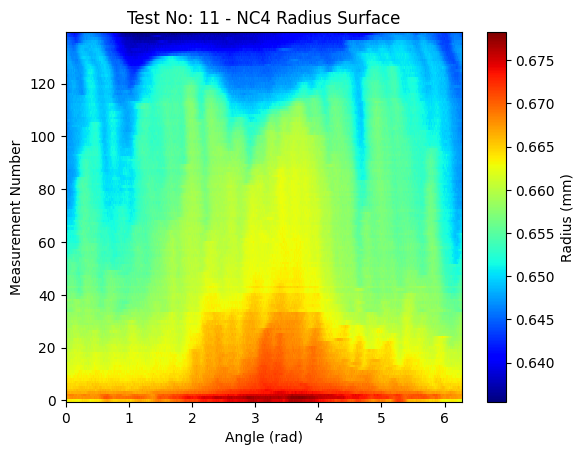

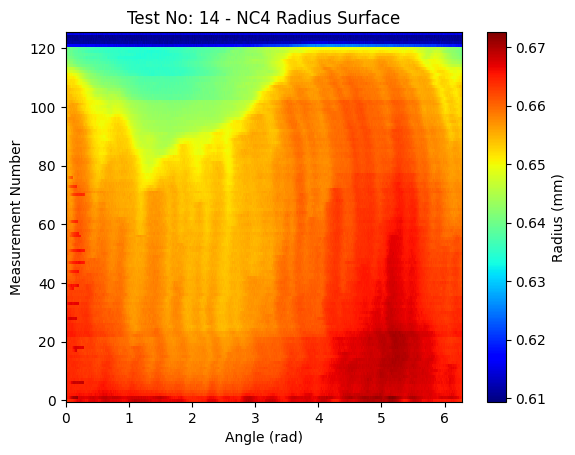

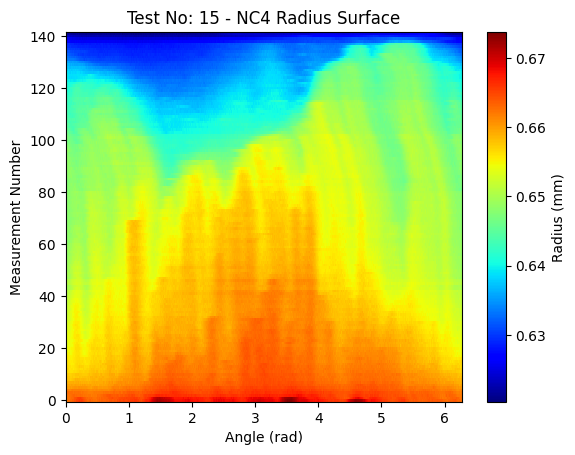

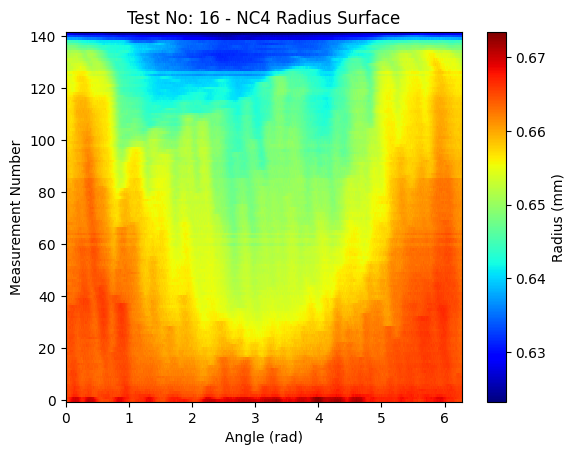

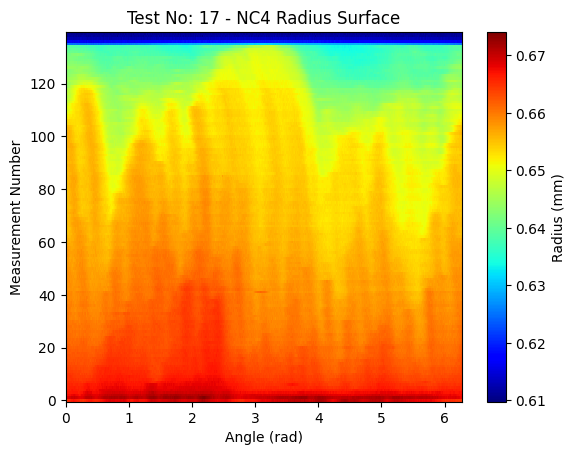

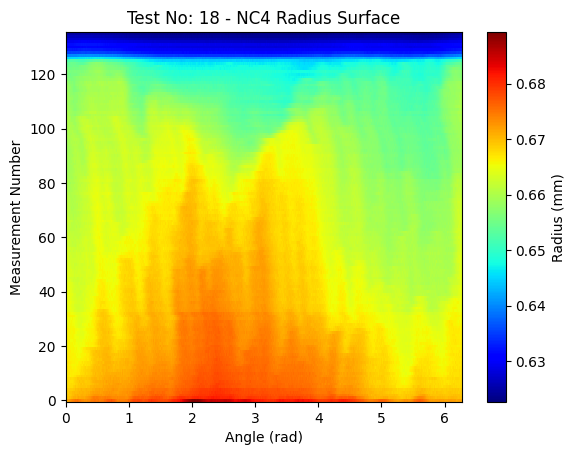

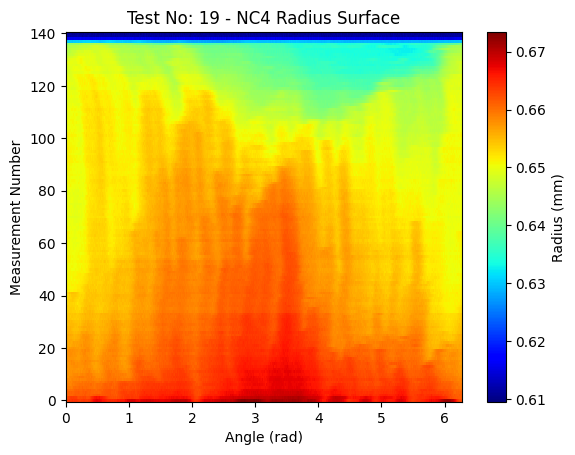

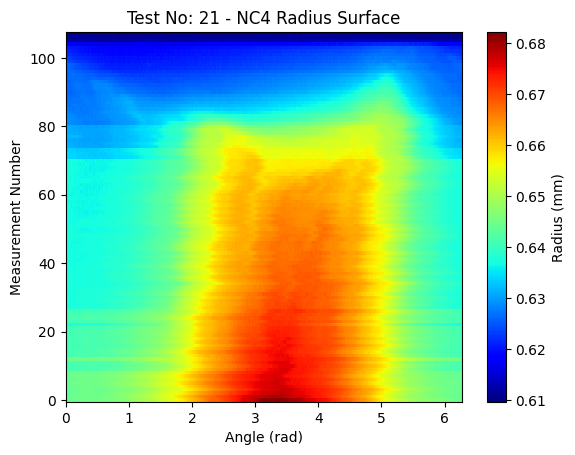

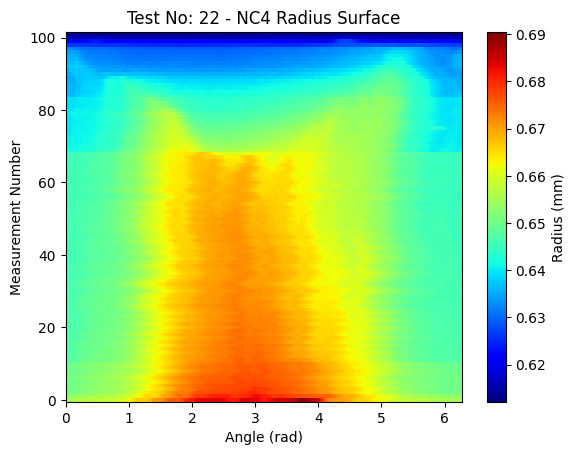

In [112]:
for exp in exps[4:]:
    exp.nc4.plot_surf()